In [1]:
## Load libraries
! pip3 install POT

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import ot
import torch
from torch import nn, optim
from scipy.stats import linregress
from scipy.optimize import curve_fit

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]

In [2]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

def find_sinkhorn_map_nd(X0, Y0, lambd = 1e-3, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.sinkhorn(a, b, M, reg=lambd, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [655]:
from numpy.random import default_rng

rng = default_rng()

def coll_OT_matdist(X,Y):
    Np = X.shape[0]
    dim = X.shape[1]
    C = np.zeros((Np,Np))
    M = np.zeros((Np,Np))
    for i in range(Np):
        C[i,:] = np.sum((X[i:i+1,:]-Y)**2, axis=1)
    #M = C.copy()
    #M = np.exp( C)
    M = np.exp( C/np.var(C) )
    #M = np.exp( C/(1000-dim) )  #**np.log(dim+1)
    #M = M / np.var(M)**0.5

    #M = C ** np.log10(10+dim)
    #M = M / np.var(M)**0.5
    #for i in range(Np):
    #    M[:,i] = M[:,i] / np.sum(M[:,i])
    #hist_tr = [np.matrix.trace(M)/Np]
    #M = C.copy()
    #for i in range(Np):
    #    M[i,:] = np.exp( M[i,:]/np.var(M[i,:])/2.0 )
    hist_tr = [np.mean( np.sum( (X-Y)**2, axis=1 )  )]
    for k in range(10000):
        iss = rng.choice(Np, size=Np, replace=False)
        i1s = iss[:int(Np/2)]
        i2s = iss[int(Np/2):]
        for j in range(len(i1s)):
            id1 = i1s[j]
            id2 = i2s[j]
            if M[id1, id2] + M[id2, id1] - M[id1, id1] - M[id2, id2] < 0:
                temp = M[:,id1].copy()
                M[:,id1] = M[:,id2].copy()
                M[:,id2] = temp.copy()
                    
                temp = Y[id1].copy()
                Y[id1] = Y[id2].copy()
                Y[id2] = temp.copy()

        #hist_tr.append(np.matrix.trace(M)/Np)
        hist_tr.append( np.mean( np.sum( (X-Y)**2, axis=1 )  ) )
    return X, Y, np.array(hist_tr), M

error:  0.1354780579672337
error:  0.09494488205848117
error:  0.06353864131201838
error:  0.044098659066636715
error:  0.02879922715591627
error:  0.018060989383702458
error:  0.012113784681594054
error:  0.009314980452922667


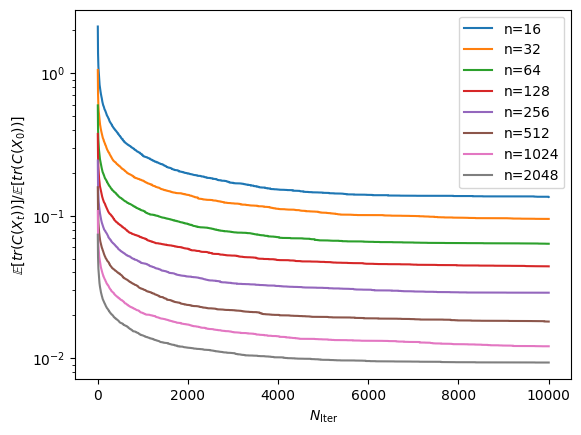

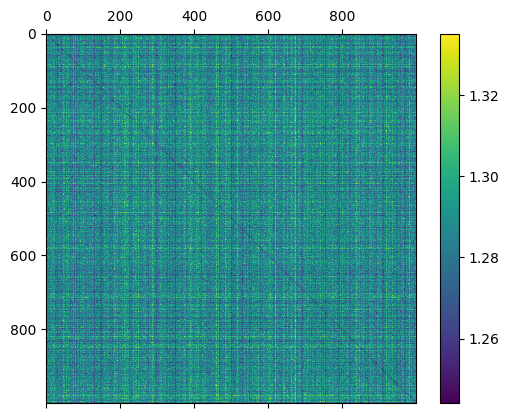

In [656]:
Np = 1000
dims = [16, 32, 64, 128, 256, 512, 1024, 2048]
plt.figure()
for dim in dims:
    X0 = np.random.normal(0.0,1,(Np, dim));
    Y0 = np.random.normal(0.0,1,(Np, dim));
    
    X = X0.copy()
    Y = Y0.copy()
    #X = X/100 #np.var(X)**0.01#(1/dim/2)
    #Y = Y/100 #np.var(Y)**0.01#(1/dim/2)
    X, Y, hist_tr, M = coll_OT_matdist(X, Y)
    #X = X*100
    #Y = Y*100
    w = np.mean( np.sum( (X-Y)**2, axis=1 )  )
    
    Xemd = X0.copy()
    Yemd = Y0.copy()
    Xemd, Yemd = find_optimal_map_nd(Xemd, Yemd)
    w2 = np.mean( np.sum( (Xemd-Yemd)**2, axis=1 )  )
    print("error: ", abs(w-w2)/w2)
    
    plt.plot([j+1 for j in range(len(hist_tr))], abs(hist_tr-w2)/w2, label="n="+str(dim))
    #plt.plot([j+1 for j in range(len(hist_tr))], abs(hist_tr), label="n="+str(dim))
#plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\mathbb{E}[tr(C(X_t))]/\mathbb{E}[tr(C(X_0))]$")
plt.xlabel(r"$N_\mathrm{Iter}$")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(M)
fig.colorbar(cax)


### Np = 100
dim = 1
X = np.random.normal(0,1,(Np, dim))# X = X/np.max(abs(X))
Y = np.random.normal(0,1,(Np, dim))# Y = Y/np.max(abs(Y))
    
C = np.zeros((Np,Np))
M = np.zeros((Np,Np))
for i in range(Np):
    C[i,:] = np.sum((X[i:i+1,:]-Y)**2, axis=1)

M = np.exp( C/(1000-dim) )  #**np.log(dim+1)
M = M / np.var(M)**0.5
#for i in range(Np):
#    M[i,:] =  M[i,:] / np.sum(M[i,:])
print(np.var(C))

print(np.var(M))

fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(C)
fig.colorbar(cax)

fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(M)
fig.colorbar(cax)

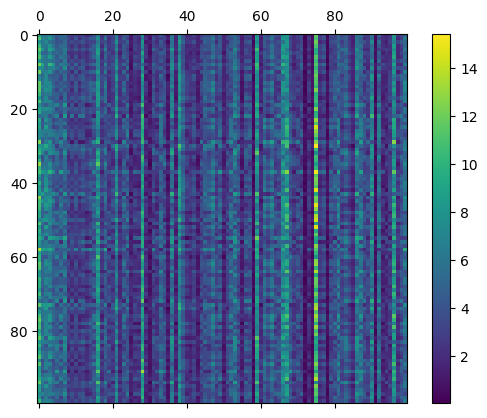

In [155]:
Xemd = X0.copy()
Yemd = Y0.copy()
Xemd, Yemd = find_optimal_map_nd(Xemd, Yemd)

np.sum(np.sum((Xemd-Yemd)**2,axis=1), axis=0)/Np

138.623414507503

In [148]:
np.sum(np.sum((X0-Y0)**2,axis=1), axis=0)/Np

200.1608558760527